**Code**

Episode 1/500, Score: 26.0, Epsilon: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Episode 2/500, Score: 12.0, Epsilon: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Episode 3/500, Score: 21.0, Epsilon: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Episode 4/500, Score: 13.0, Epsilon: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 5/500, Score: 15.0, Epsilon: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Episode 6/500, Score: 35.0, Epsilon: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Episode 7/500, Score: 14.0, Epsilon: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━

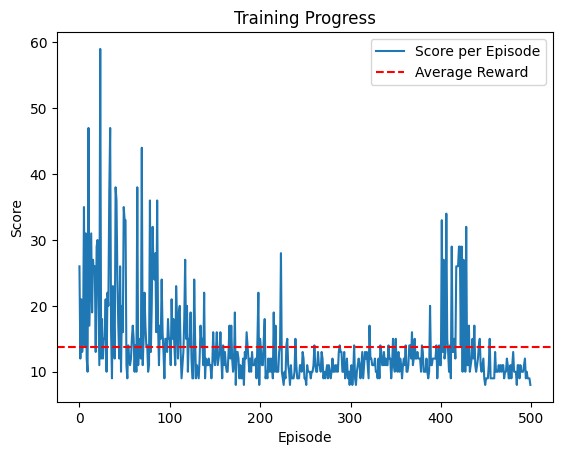

In [20]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import random

# Set up the CartPole environment
env = gym.make('CartPole-v1')

# Define the DQN model
def create_q_model(input_shape, action_space):
    model = tf.keras.Sequential()
    model.add(layers.Dense(24, input_shape=input_shape, activation='relu'))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(action_space, activation='linear'))
    return model

# Define hyperparameters
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration probability
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
batch_size = 32
memory_size = 2000

# Initialize models and memory
action_space = env.action_space.n
state_shape = env.observation_space.shape
model = create_q_model(state_shape, action_space)
target_model = create_q_model(state_shape, action_space)

# Compile the models
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
target_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

memory = deque(maxlen=memory_size)

# Function to select action
def select_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    q_values = model.predict(state)
    return np.argmax(q_values[0])

# Function to train the model
def train_model():
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*minibatch)
    states = np.vstack(states)
    next_states = np.vstack(next_states)
    targets = model.predict(states)
    target_next = target_model.predict(next_states)
    
    for i in range(batch_size):
        if dones[i]:
            targets[i][actions[i]] = rewards[i]
        else:
            targets[i][actions[i]] = rewards[i] + gamma * np.amax(target_next[i])
    
    model.fit(states, targets, epochs=1, verbose=0)

# Training loop
episodes = 500
scores = []
average_rewards = []

for e in range(episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_shape[0]])
    score = 0
    for time in range(500):
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_shape[0]])
        memory.append((state, action, reward, next_state, done))
        state = next_state
        score += reward
        if done:
            break
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    train_model()
    target_model.set_weights(model.get_weights())
    scores.append(score)
    average_rewards.append(score)
    print(f"Episode {e+1}/{episodes}, Score: {score}, Epsilon: {epsilon:.2f}")

# Calculate average reward
average_reward = np.mean(average_rewards)
print("Average Reward per Episode:", average_reward)

# Plot results
plt.plot(scores, label='Score per Episode')
plt.axhline(y=average_reward, color='r', linestyle='--', label='Average Reward')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.title('Training Progress')
plt.show()
